## Deeppoly PyTorch Examples
[link](https://popl19.sigplan.org/details/POPL-2019-Research-Papers/58/An-Abstract-Domain-for-Certifying-Neural-Networks)  
[official tool](https://github.com/eth-sri/eran)  
[alternative tool](https://github.com/XuankangLin/DiffAbs/blob/master/diffabs/deeppoly.py)

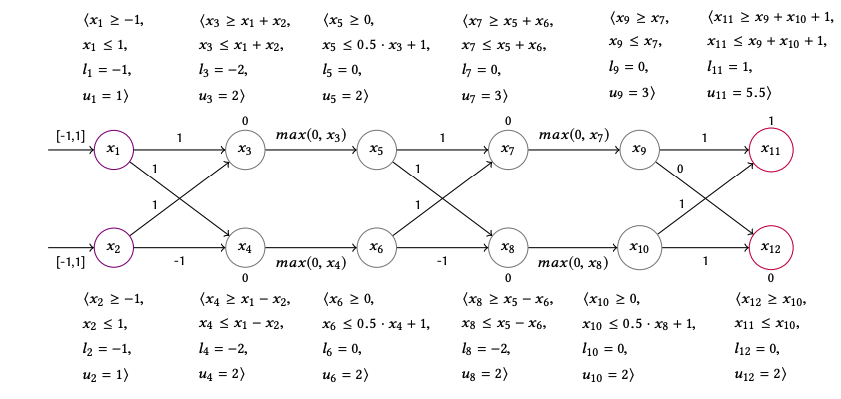

**Code Below still needs tunes!!**

In [1]:
from typing import Tuple, Union

import torch as th
from torch import nn

## Define Abstract Element
### Domain Type
In deeppoly, the concrete abstract elements are intervals, but this element will keep its relation to previous layer's neurons.

### Element Operation
We need support the add between domains, add between abstract element and tensors, multiply between abstract elements and tensors. See `__add__`, `__rmatmul__` below. 

### Concretize the Element
Compute the overapproximation in the "box" form. See `concretize` function below.

In [2]:
class AbsEle:
    def __init__(self, lb_coef, ub_coef, lb_cnst, ub_cnst, inp_conc_lb, inp_conc_ub):
        self.lb_coef = lb_coef  # lower polyhedral constraint
        self.ub_coef = ub_coef  # upper polyhedral constraint
        self.lb_cnst = lb_cnst  # lower polyhedral constant
        self.ub_cnst = ub_cnst  # upper polyhedral constant
        self.inp_conc_lb = inp_conc_lb  # concrete lower bounds of input variables
        self.inp_conc_ub = inp_conc_ub  # concrete upper bounds of input variables

    @classmethod
    def create_with_bound(cls, inp_conc_lb: th.Tensor, inp_conc_ub: th.Tensor) -> 'AbsEle':
        coef = th.eye(len(inp_conc_lb))
        cnst = th.zeros(len(inp_conc_lb))
        return cls(lb_coef=coef, ub_coef=coef,
                   lb_cnst=cnst, ub_cnst=cnst,
                   inp_conc_lb=inp_conc_lb, inp_conc_ub=inp_conc_ub)

    def concretize(self) -> Tuple[th.Tensor, th.Tensor]:
        return self.compute_conc_lb(), self.compute_conc_ub()

    def compute_conc_lb(self) -> th.Tensor:
        pos_coef = self.lb_coef * (self.lb_coef >= 0)
        neg_coef = self.lb_coef * (self.lb_coef <= 0)

        pos_mul_lb = pos_coef @ self.inp_conc_lb
        neg_mul_ub = neg_coef @ self.inp_conc_ub

        return self.lb_cnst + pos_mul_lb + neg_mul_ub

    def compute_conc_ub(self) -> th.Tensor:
        pos_coef = self.ub_coef * (self.ub_coef >= 0)
        neg_coef = self.ub_coef * (self.ub_coef <= 0)

        pos_mul_ub = pos_coef @ self.inp_conc_ub
        neg_mul_lb = neg_coef @ self.inp_conc_lb

        return self.ub_cnst + pos_mul_ub + neg_mul_lb

    def __add__(self, other: Union[th.Tensor, 'AbsEle']) -> 'AbsEle':
        if isinstance(other, th.Tensor):
            return AbsEle(self.lb_coef, self.ub_coef,
                          self.lb_cnst + other, self.ub_cnst + other,
                          self.inp_conc_lb, self.inp_conc_ub)
        elif isinstance(other, AbsEle):
            assert (self.inp_conc_lb == other.inp_conc_lb).all()
            return AbsEle(other.lb_coef + self.lb_coef,
                          other.ub_coef + self.ub_coef,
                          other.lb_cnst + self.lb_cnst,
                          other.ub_cnst + self.ub_cnst,
                          self.inp_conc_lb, self.inp_conc_ub)
        else:
            raise NotImplementedError()

    def __radd__(self, other: Union[th.Tensor, 'AbsEle']) -> 'AbsEle':
        return self.__add__(other)

    def __rmatmul__(self, other: th.Tensor) -> 'AbsEle':
        pos_part = other * (other >= 0)
        neg_part = other * (other < 0)

        new_lb_coef = self.lb_coef @ pos_part + self.ub_coef @ neg_part
        new_ub_coef = self.ub_coef @ pos_part + self.lb_coef @ neg_part
        new_lb_cnst = self.lb_cnst @ pos_part + self.ub_cnst @ neg_part
        new_ub_cnst = self.ub_cnst @ pos_part + self.lb_cnst @ neg_part

        return AbsEle(new_lb_coef, new_ub_coef,
                      new_lb_cnst, new_ub_cnst,
                      self.inp_conc_lb, self.inp_conc_ub)

    def __getitem__(self, key) -> 'AbsEle':
        return AbsEle(self.lb_coef[key], self.ub_coef[key],
                      self.lb_cnst[key], self.ub_cnst[key],
                      self.inp_conc_lb[key], self.inp_conc_ub[key])

### First step in the example figure

1. Set the input lower bound as \[-1, -1\].   
2. Set the input upper bound as \[1, 1\].  
3. The affine transformation matrix is 
$\left[\begin{array}{ll} 1 & 1 \\ 1 & -1 \end{array} \right]$. 
4. No bias need to be consider here.  

In [3]:
inp_lb = th.tensor([-1.0, -1.0])
inp_ub = th.tensor([1.0, 1.0])

ele = AbsEle.create_with_bound(inp_lb, inp_ub)

In [4]:
w1 = th.tensor([[1.0, 1.0], [1.0, -1.0]])
new_ele = w1 @ ele
conc_lb_1, conc_ub_1 = new_ele.concretize()
print(conc_lb_1, conc_ub_1)

tensor([-2., -2.]) tensor([2., 2.])


## Define ReLU

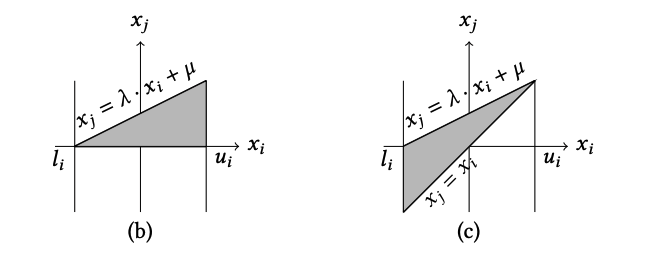

If $u_i < 0$, $x_j = 0$. Clear.   
If $l_i > 0$, $x_j = x_i$. Persevere.   
When $u_i > 0 \land l_i < 0$, either (b) or (c) will be chosen to approximate ReLU. Depends on the area of the gray part, which can be measured with relationship between $|l_i|$ and $|u_i|$. Specifically, when $|l_i| > |u_i|$, choose $k = 0$ for minimum area; when $|l_i| < |u_i|$, choose $k = 1$, where $k$ is the slope of the lower line. $k = 0$ is (b), $k = 1$ is (c). 

In [5]:
class ReLU(nn.ReLU):
    def __init__(self, inplace: bool = False):
        super().__init__(inplace)
        self.inp = None
        self.inp_lb, self.inp_ub = None, None

    def forward(self, inp: Union[th.Tensor, AbsEle]) -> Union[th.Tensor, AbsEle]:
        self.inp = inp

        if isinstance(inp, th.Tensor):
            return super(ReLU, self).forward(inp)
        elif isinstance(inp, AbsEle):
            self.inp_lb, self.inp_ub = inp.concretize()
            new_ub_coef, new_ub_cnst = self._compute_new_ub()
            new_lb_coef, new_lb_cnst = self._compute_new_lb()

            new_ele = AbsEle(new_lb_coef, new_ub_coef,
                             new_lb_cnst, new_ub_cnst,
                             inp.inp_conc_lb, inp.inp_conc_ub)

            return new_ele
        else:
            raise NotImplementedError()

    def _compute_new_ub(self) -> Tuple[th.Tensor, th.Tensor]:
        exact_coef, exact_cnst, approxed = self._exact_part(self.inp.ub_coef, self.inp.ub_cnst)

        approx_coef = th.zeros([len(self.inp_lb), len(self.inp_lb)])
        approx_cnst = th.zeros_like(self.inp_lb)
        _denominator = self.inp_ub - self.inp_lb
        approx_coef[approxed] = self.inp_ub * self.inp.ub_coef[approxed] / _denominator
        approx_cnst[approxed] = self.inp_ub * (self.inp.ub_cnst[approxed] - self.inp_lb) / (self.inp_ub - self.inp_lb)

        new_coef = exact_coef + approx_coef
        new_cnst = exact_cnst + approx_cnst
        return new_coef, new_cnst

    def _compute_new_lb(self) -> Tuple[th.Tensor, th.Tensor]:
        exact_coef, exact_cnst, approxed = self._exact_part(self.inp.lb_coef, self.inp.lb_cnst)

        approx_coef = th.zeros([len(self.inp_lb), len(self.inp_lb)])
        approx_cnst = th.zeros_like(self.inp_lb)

        k_equals_1 = th.abs(self.inp_lb[approxed]) < th.abs(self.inp_ub[approxed])
        approx_coef[approxed.nonzero()[k_equals_1]] = self.inp.lb_coef[approxed.nonzero()[k_equals_1]]
        approx_cnst[approxed.nonzero()[k_equals_1]] = self.inp.lb_cnst[approxed.nonzero()[k_equals_1]]

        new_coef = exact_coef + approx_coef
        new_cnst = exact_cnst + approx_cnst
        return new_coef, new_cnst

    def _exact_part(self, coef, cnst):
        all_clear = self.inp_ub <= 0
        not_all_clear = ~ all_clear
        all_pres = (self.inp_lb >= 0) & not_all_clear
        approxed = not_all_clear & (~ all_pres)

        cleared_coef = th.zeros([len(self.inp_lb), len(self.inp_lb)])
        cleared_cnst = th.zeros_like(self.inp_lb)
        exact_coef = cleared_coef
        exact_cnst = cleared_cnst

        pers_coef = coef[all_pres]
        pers_cnst = cnst[all_pres]
        exact_coef[all_pres] = pers_coef
        exact_cnst[all_pres] = pers_cnst

        return exact_coef, exact_cnst, approxed

### Second step in example
Passing the `new_ele` to relu. 

In [6]:
relu = ReLU()
new_ele = relu(new_ele)
conc_lb_2, conc_ub_2 = new_ele.concretize()
print(conc_lb_2, conc_ub_2)

tensor([0., 0.]) tensor([2., 2.])
